# Colab init

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
import os
sys.path.append("/content/drive/MyDrive/MLEX3")
%cd /content/drive/MyDrive/MLEX3/

/content/drive/MyDrive/MLEX3


In [3]:
!pip install adversarial-robustness-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.8 MB/s eta 0:00:00


# Libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Softmax, Lambda
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import BasicIterativeMethod
from art.attacks.evasion import CarliniL2Method
from art.attacks.evasion import UniversalPerturbation

# Loading and splitting dataset

In [5]:
def load_dataset(directory, size=(64,64)):
    X, y = [], []
    for folder in os.listdir(directory):
        label = int(folder[1:])  # folders 's1', 's2'...
        folder_path = os.path.join(directory, folder)
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path)
            image = image.resize(size) # resize to 64x64
            X.append(np.array(image))
            y.append(label)
    X = np.array(X) / 255.0  # normalize
    y = np.array(y) - 1  # labels start 0, not 1
    return X, y

In [6]:
X, y = load_dataset('data/')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train = X_train.reshape((-1, 64, 64, 1))
X_val = X_val.reshape((-1, 64, 64, 1))
X_test = X_test.reshape((-1, 64, 64, 1))

# Build and train model

In [7]:
def build_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(40, activation='softmax')  # 40 classes
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [8]:
model = build_model((64, 64, 1))

# instance early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/50
15/15 [==============================] - 6s 22ms/step - loss: 3.7216 - accuracy: 0.0333 - val_loss: 3.6817 - val_accuracy: 0.0125
Epoch 2/50
15/15 [==============================] - 0s 7ms/step - loss: 3.6416 - accuracy: 0.0917 - val_loss: 3.6978 - val_accuracy: 0.0125
Epoch 3/50
15/15 [==============================] - 0s 7ms/step - loss: 3.5006 - accuracy: 0.1125 - val_loss: 3.4721 - val_accuracy: 0.1125
Epoch 4/50
15/15 [==============================] - 0s 7ms/step - loss: 3.1407 - accuracy: 0.2750 - val_loss: 3.0791 - val_accuracy: 0.2125
Epoch 5/50
15/15 [==============================] - 0s 8ms/step - loss: 2.4684 - accuracy: 0.4000 - val_loss: 2.5335 - val_accuracy: 0.3500
Epoch 6/50
15/15 [==============================] - 0s 8ms/step - loss: 1.8307 - accuracy: 0.5667 - val_loss: 2.0864 - val_accuracy: 0.4875
Epoch 7/50
15/15 [==============================] - 0s 8ms/step - loss: 1.2167 - accuracy: 0.7333 - val_loss: 1.4354 - val_accuracy: 0.5875
Epoch 8/50
15/15 [=

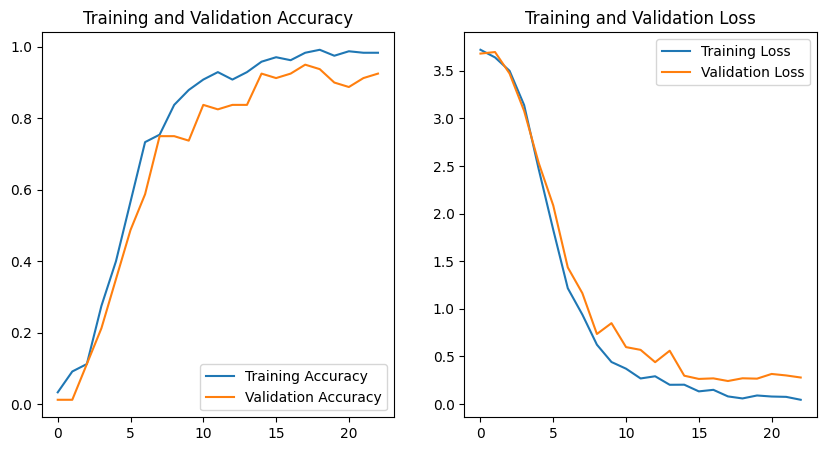

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [10]:
def l0_norm(real, adversarial):
    return np.sum(real != adversarial)

def l2_norm(real, adversarial):
    return np.linalg.norm(real - adversarial)

def linf_norm(real, adversarial):
    return np.max(np.abs(real - adversarial))

# Fast gradient sign method

In [50]:
loss_func = SparseCategoricalCrossentropy()
classifier = TensorFlowV2Classifier(clip_values=(0, 1), model=model, nb_classes=40, input_shape=(64, 64, 1), loss_object=loss_func)
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.01)
X_test_fgsm = attack_fgsm.generate(x=X_test)

In [51]:
l0_dists = []
l2_dists = []
linf_dists = []

for real_img, adv_img in zip(X_test, X_test_fgsm):
    l0_dists.append(l0_norm(real_img, adv_img))
    l2_dists.append(l2_norm(real_img, adv_img))
    linf_dists.append(linf_norm(real_img, adv_img))

avg_l0 = np.mean(l0_dists)
avg_l2 = np.mean(l2_dists)
avg_linf = np.mean(linf_dists)
std_l0 = np.std(l0_dists)
std_l2 = np.std(l2_dists)
std_linf = np.std(linf_dists)

print(f"Average L0 Distortion: {avg_l0}")
print(f"Average L2 Distortion: {avg_l2}")
print(f"Average L∞ Distortion: {avg_linf}")
print(f"Average L0 Distortion: {std_l0}")
print(f"Average L2 Distortion: {std_l2}")
print(f"Average L∞ Distortion: {std_linf}")

Average L0 Distortion: 4096.0
Average L2 Distortion: 0.619942035773829
Average L∞ Distortion: 0.010000020849938507
Average L0 Distortion: 0.0
Average L2 Distortion: 0.0001386758284541449
Average L∞ Distortion: 0.0


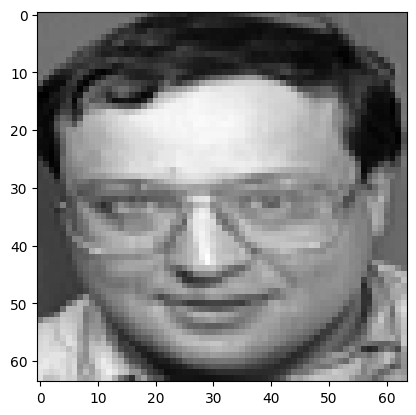

In [52]:
plt.imshow(X_test[0].squeeze(), cmap='gray')

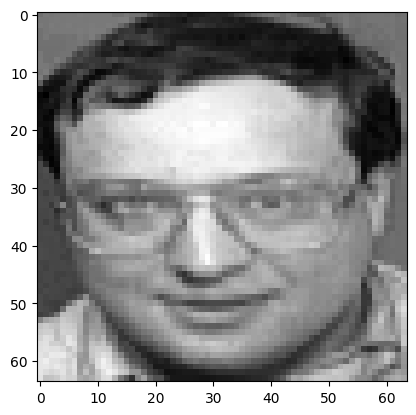

In [53]:
plt.imshow(X_test_fgsm[0].squeeze(), cmap='gray')

In [54]:
score_clean = model.evaluate(x=X_test, y=y_test)
score_fgsm = model.evaluate(x=X_test_fgsm, y=y_test)

print(f"Clean test set loss: {score_clean[0]:.2f} "
      f"vs FGSM test set loss: {score_fgsm[0]:.2f}")

print(f"Clean test set accuracy: {score_clean[1]:.2f} "
      f"vs FGSM test set accuracy: {score_fgsm[1]:.2f}")

3/3 [==============================] - 0s 5ms/step - loss: 0.6692 - accuracy: 0.8125
Clean test set loss: 0.39 vs FGSM test set loss: 0.67
Clean test set accuracy: 0.94 vs FGSM test set accuracy: 0.81


1/1 [==============================] - 0s 25ms/step


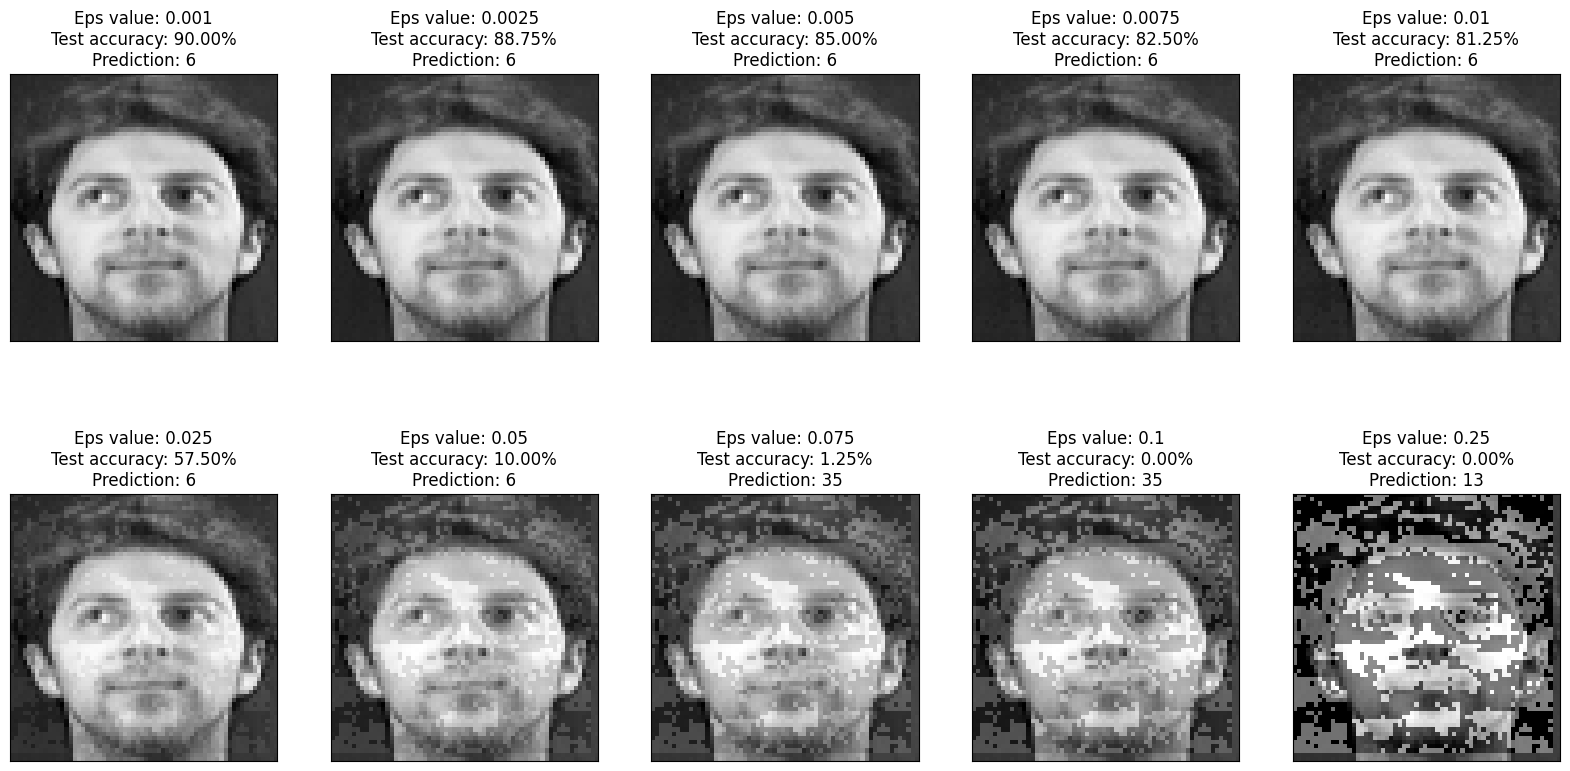

In [55]:
# plot setting
nrows, ncols = 2, 5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))

eps_to_try = [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25]
counter = 0

for i in range(nrows):
    for j in range(ncols):

        attack_fgsm = FastGradientMethod(estimator=classifier, eps=eps_to_try[counter])
        X_test_fgsm = attack_fgsm.generate(x=X_test)

        axes[i, j].imshow(X=X_test_fgsm[5].squeeze(), cmap='gray')
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])

        test_score = classifier._model.evaluate(x=X_test_fgsm, y=y_test)[1]
        prediction = np.argmax(model.predict(x=np.expand_dims(a=X_test_fgsm[5], axis=0)))

        axes[i, j].set_title(
            label=f"Eps value: {eps_to_try[counter]}\n"
            f"Test accuracy: {test_score * 100:.2f}%\n"
            f"Prediction: {prediction}"
            )

        counter += 1

plt.show()

# Iterative Fast Gradient Sign method

In [56]:
loss_func = SparseCategoricalCrossentropy()
classifier = TensorFlowV2Classifier(clip_values=(0, 1), model=model, nb_classes=40, input_shape=(64, 64, 1), loss_object=loss_func)
attack_ifgsm = BasicIterativeMethod(estimator=classifier, eps=0.01, eps_step=0.001, max_iter=10)
X_test_ifgsm = attack_ifgsm.generate(x=X_test)

PGD - Batches: 0it [00:00, ?it/s]

In [57]:
l0_dists = []
l2_dists = []
linf_dists = []

for real_img, adv_img in zip(X_test, X_test_ifgsm):
    l0_dists.append(l0_norm(real_img, adv_img))
    l2_dists.append(l2_norm(real_img, adv_img))
    linf_dists.append(linf_norm(real_img, adv_img))

avg_l0 = np.mean(l0_dists)
avg_l2 = np.mean(l2_dists)
avg_linf = np.mean(linf_dists)
std_l0 = np.std(l0_dists)
std_l2 = np.std(l2_dists)
std_linf = np.std(linf_dists)

print(f"Average L0 Distortion: {avg_l0}")
print(f"Average L2 Distortion: {avg_l2}")
print(f"Average L∞ Distortion: {avg_linf}")
print(f"Average L0 Distortion: {std_l0}")
print(f"Average L2 Distortion: {std_l2}")
print(f"Average L∞ Distortion: {std_linf}")

Average L0 Distortion: 4096.0
Average L2 Distortion: 0.5776220192133243
Average L∞ Distortion: 0.010000012569567738
Average L0 Distortion: 0.0
Average L2 Distortion: 0.01002266778946299
Average L∞ Distortion: 7.164301764724797e-10


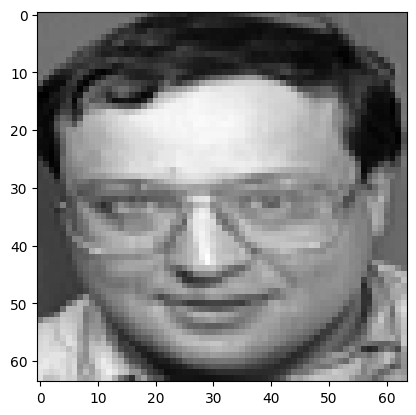

In [58]:
plt.imshow(X_test[0].squeeze(), cmap='gray')

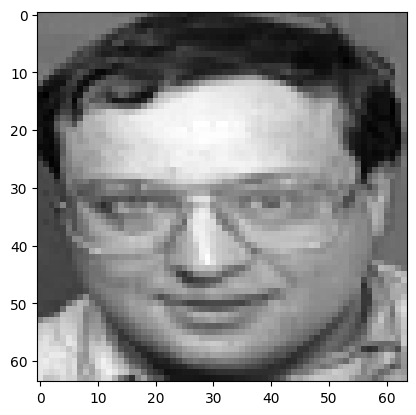

In [59]:
plt.imshow(X_test_ifgsm[0].squeeze(), cmap='gray')

In [60]:
score_clean = model.evaluate(x=X_test, y=y_test)
score_ifgsm = model.evaluate(x=X_test_ifgsm, y=y_test)

print(f"Clean test set loss: {score_clean[0]:.2f} "
      f"vs IFGSM test set loss: {score_ifgsm[0]:.2f}")

print(f"Clean test set accuracy: {score_clean[1]:.2f} "
      f"vs IFGSM test set accuracy: {score_ifgsm[1]:.2f}")

3/3 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.8125
Clean test set loss: 0.39 vs IFGSM test set loss: 0.69
Clean test set accuracy: 0.94 vs IFGSM test set accuracy: 0.81


# Carlini Wagner

In [22]:
loss_func = SparseCategoricalCrossentropy()
classifier = TensorFlowV2Classifier(clip_values=(0, 1), model=model, nb_classes=40, input_shape=(64, 64, 1), loss_object=loss_func)
attack_cw = CarliniL2Method(classifier=classifier, confidence=0.1, batch_size=16, learning_rate=0.01, max_iter=10)
X_test_cw = attack_cw.generate(x=X_test)

C&W L_2:   0%|          | 0/5 [00:00<?, ?it/s]

In [23]:
l0_dists = []
l2_dists = []
linf_dists = []

for real_img, adv_img in zip(X_test, X_test_cw):
    l0_dists.append(l0_norm(real_img, adv_img))
    l2_dists.append(l2_norm(real_img, adv_img))
    linf_dists.append(linf_norm(real_img, adv_img))

avg_l0 = np.mean(l0_dists)
avg_l2 = np.mean(l2_dists)
avg_linf = np.mean(linf_dists)
std_l0 = np.std(l0_dists)
std_l2 = np.std(l2_dists)
std_linf = np.std(linf_dists)

print(f"Average L0 Distortion: {avg_l0}")
print(f"Average L2 Distortion: {avg_l2}")
print(f"Average L∞ Distortion: {avg_linf}")
print(f"Average L0 Distortion: {std_l0}")
print(f"Average L2 Distortion: {std_l2}")
print(f"Average L∞ Distortion: {std_linf}")

Average L0 Distortion: 4095.9875
Average L2 Distortion: 0.608319391509718
Average L∞ Distortion: 0.07225063510093035
Average L0 Distortion: 0.11110243021644485
Average L2 Distortion: 0.5679685455411474
Average L∞ Distortion: 0.07272001873774803


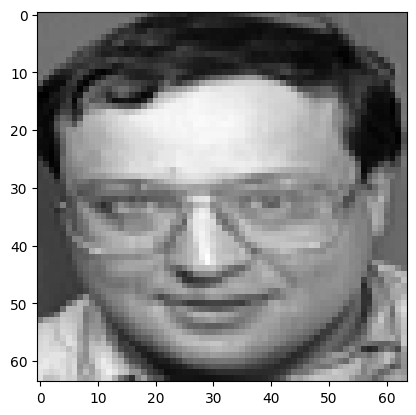

In [24]:
plt.imshow(X_test[0].squeeze(), cmap='gray')

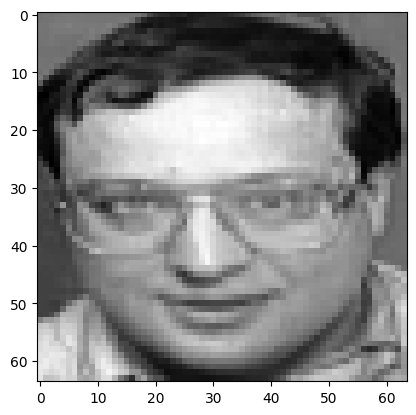

In [25]:
plt.imshow(X_test_cw[0].squeeze(), cmap='gray')

In [26]:
score_clean = model.evaluate(x=X_test, y=y_test)
score_cw = model.evaluate(x=X_test_cw, y=y_test)

print(f"Clean test set loss: {score_clean[0]:.2f} "
      f"vs CW test set loss: {score_cw[0]:.2f}")

print(f"Clean test set accuracy: {score_clean[1]:.2f} "
      f"vs CW test set accuracy: {score_cw[1]:.2f}")

3/3 [==============================] - 0s 5ms/step - loss: 1.0898 - accuracy: 0.2875
Clean test set loss: 0.39 vs CW test set loss: 1.09
Clean test set accuracy: 0.94 vs CW test set accuracy: 0.29


# Universal Perturbation

In [61]:
loss_func = SparseCategoricalCrossentropy()
classifier = TensorFlowV2Classifier(clip_values=(0, 1), model=model, nb_classes=40, input_shape=(64, 64, 1), loss_object=loss_func)
attack_up = UniversalPerturbation(classifier=classifier, attacker='fgsm', eps=0.01)
X_test_up = attack_up.generate(x=X_test)

Universal perturbation:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
l0_dists = []
l2_dists = []
linf_dists = []

for real_img, adv_img in zip(X_test, X_test_up):
    l0_dists.append(l0_norm(real_img, adv_img))
    l2_dists.append(l2_norm(real_img, adv_img))
    linf_dists.append(linf_norm(real_img, adv_img))

avg_l0 = np.mean(l0_dists)
avg_l2 = np.mean(l2_dists)
avg_linf = np.mean(linf_dists)
std_l0 = np.std(l0_dists)
std_l2 = np.std(l2_dists)
std_linf = np.std(linf_dists)

print(f"Average L0 Distortion: {avg_l0}")
print(f"Average L2 Distortion: {avg_l2}")
print(f"Average L∞ Distortion: {avg_linf}")
print(f"Average L0 Distortion: {std_l0}")
print(f"Average L2 Distortion: {std_l2}")
print(f"Average L∞ Distortion: {std_linf}")

Average L0 Distortion: 4095.9875
Average L2 Distortion: 0.619998991895317
Average L∞ Distortion: 0.010000000000000009
Average L0 Distortion: 0.11110243021644485
Average L2 Distortion: 8.960456198092786e-06
Average L∞ Distortion: 0.0


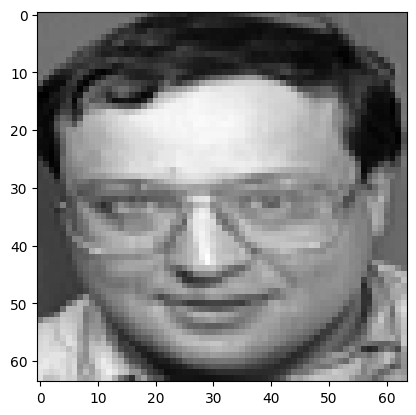

In [63]:
plt.imshow(X_test[0].squeeze(), cmap='gray')

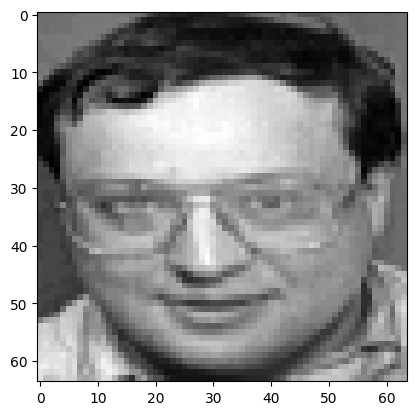

In [64]:
plt.imshow(X_test_up[0].squeeze(), cmap='gray')

In [65]:
score_clean = model.evaluate(x=X_test, y=y_test)
score_up = model.evaluate(x=X_test_up, y=y_test)

print(f"Clean test set loss: {score_clean[0]:.2f} "
      f"vs UP test set loss: {score_up[0]:.2f}")

print(f"Clean test set accuracy: {score_clean[1]:.2f} "
      f"vs UP test set accuracy: {score_up[1]:.2f}")

3/3 [==============================] - 0s 5ms/step - loss: 0.3750 - accuracy: 0.9125
Clean test set loss: 0.39 vs UP test set loss: 0.37
Clean test set accuracy: 0.94 vs UP test set accuracy: 0.91


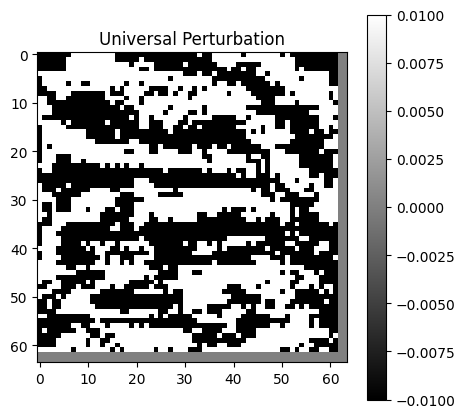

In [66]:
universal_perturbation = X_test_up - X_test

# visualization of up 
plt.figure(figsize=(5, 5))
plt.title('Universal Perturbation')
plt.imshow(universal_perturbation[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()